# KNN (K-Nearest Neighbors) and Time Series

In [35]:
import numpy as np
import pandas as pd
import ts_utils
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (8, 4)

Una algoritmo de **Regresión** en ML se define como una función $f$

$$
    f: \mathbb{R}^M \to \mathbb{R}
$$

Una algoritmo de **Clasificación** en ML se define como una función $f$

$$
    f: \mathbb{R}^M \to \{C_k\}_{k=1}^K
$$

### Clasificación

* KNN Clasificación
* Árboles de decision
* Random Forests de clasificacion
* SVM
* Regresión logística

### Regresion
* KNN Regresion
* Árboles de decision
* SVR
* Regresión Lineal

## Quick KNN

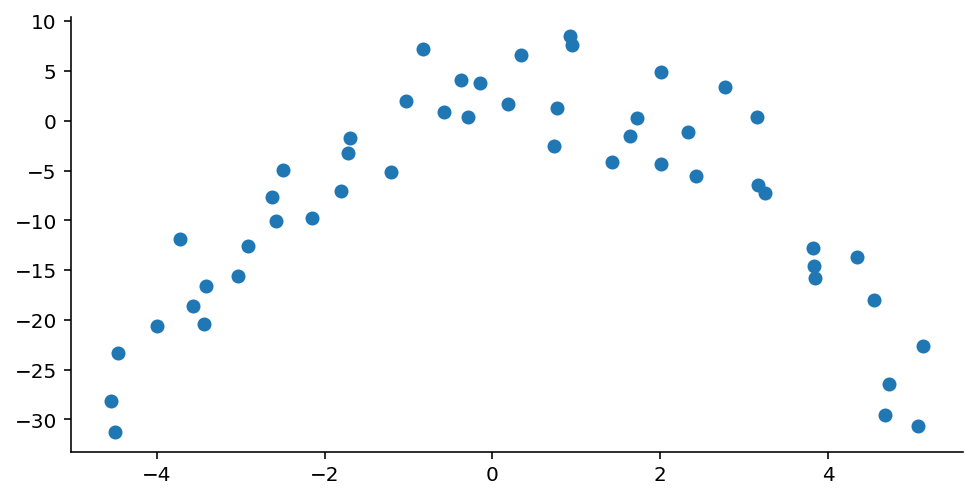

In [7]:
N = 50
np.random.seed(314)
x = np.linspace(-5, 5, N) + np.random.rand(N) * 0.5
y = 3 + x - 1.3 * x ** 2 + np.random.randn(N) * 4

plt.scatter(x, y);

### KNN de Regresión

$$
    \hat y({\bf x}) = \frac{1}{K}\sum_{n \vert {\bf x}_n \in N_{k}({\bf x})} y_n
$$

* Tengo una base de datos con $N$ observaciones
* Entreno KNN de regresión con $K = N$
* $\hat y({\bf x})$

In [31]:
from sklearn.neighbors import KNeighborsRegressor
from ipywidgets import interact, IntSlider

@interact(k=IntSlider(min=1, max=N, value=5))
def graph_knn(k):
    knn = KNeighborsRegressor(n_neighbors=k, metric="l2")
    knn.fit(x.reshape(-1, 1), y)

    xtest = np.linspace(-5, 5, 100).reshape(-1, 1)
    yhat = knn.predict(xtest)

    plt.scatter(x, y)
    plt.plot(xtest, yhat, c="tab:orange", linewidth=3)

interactive(children=(IntSlider(value=5, description='k', max=50, min=1), Output()), _dom_classes=('widget-int…

## "Aprender" una función

In [37]:
N = 50
x = np.linspace(0, 4 * np.pi, N)
y = pd.DataFrame({"S": np.sin(x)}, index=x)

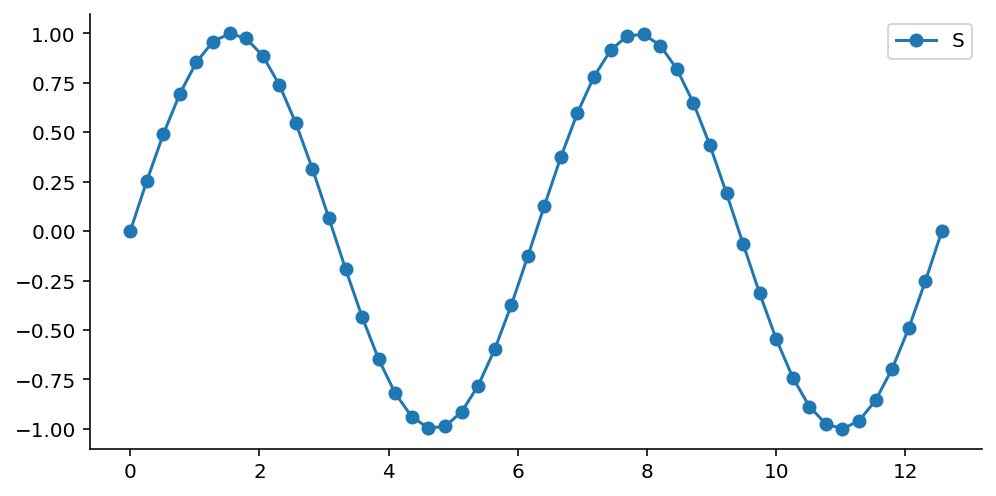

In [147]:
y.plot(marker="o")

In [41]:
X = ts_utils.ts_supervised(y, n_in=10)

X_train = X.drop("S(t)", axis=1)
y_train = X[["S(t)"]]

tsknn = KNeighborsRegressor(n_neighbors=3)
tsknn.fit(X_train, y_train)

In [53]:
X_train.iloc[[-1]]

,S(t-10),S(t-9),S(t-8),S(t-7),S(t-6),S(t-5),S(t-4),S(t-3),S(t-2),S(t-1)
12.566371,-0.545535,-0.740278,-0.886599,-0.974928,-0.999486,-0.958668,-0.855143,-0.695683,-0.490718,-0.253655


In [56]:
y_train.iloc[-1]

S(t)   -4.898587e-16
Name: 12.566370614359172, dtype: float64

In [87]:
tsknn.predict(X_train.iloc[[-1]]).item()

-6.291263806209221e-16

```
t-3, t-2, t-1 -> t
t-2, t-1, t   -> t+1
t-1, t,   t+1 -> t+2
...
T-3, T-2, T-1 -> T
```

In [134]:
from collections import deque

def sequential_estimation(model, xin, T):
    """
    Paramaters
    ----------
    model: sklearn model
        Modelo KNN a usar como estimador
    xin: np.array(1, K)
        Semilla incial del sistema
    T: int
        Número de pasos a estimar (a integrar)
    """
    K, *_ = xin.shape
    # Aquí agregaré los resultados
    estimaciones = np.zeros(T)
    xpred = deque(xin, maxlen=K)
    
    for t in range(T):
#         import pdb; pdb.set_trace()
        xin = np.array([xpred])
        S_t1 = model.predict(xin).item()
        estimaciones[t] = S_t1
        xpred.append(S_t1)
    
    return estimaciones

In [166]:
n_in = 1

X = ts_utils.ts_supervised(y, n_in=n_in)

X_train = X.drop("S(t)", axis=1)
y_train = X[["S(t)"]]

tsknn = KNeighborsRegressor(n_neighbors=1)
tsknn.fit(X_train, y_train);

```
n_in = 2
n_neighbors = 3

-> T1, T2
T3, T4
T5, T6
-> T7, T8
T9, T10
-> T11, T12
```

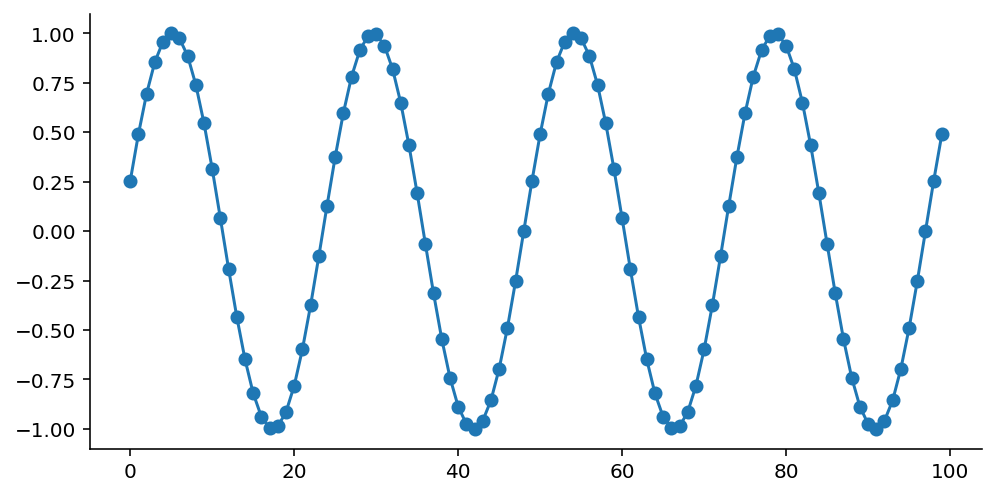

In [167]:
plt.plot(sequential_estimation(tsknn, X_train.iloc[0].values, 100), marker="o")

# Agregando Estocasticidad

In [169]:
uri = "gs://resources-gdm/weather.csv"
weather = pd.read_csv(uri, index_col=0)
weather.index = pd.to_datetime(weather.index)

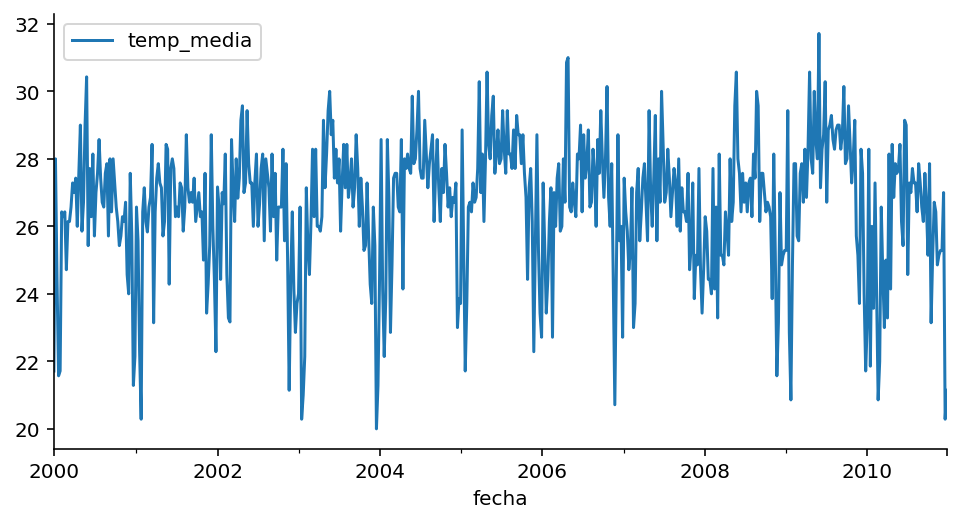

In [174]:
temp_media = weather[["temp_media"]].resample("W").mean()
temp_media_train = temp_media[:"2019"]
temp_media_test = temp_media["2020":]
temp_media["2000":"2010"].plot();

In [302]:
Xtrain = ts_utils.ts_supervised(temp_media, 2)


Xtrain, Xtest = Xtrain[:"2019"], Xtrain["2020":]

ytrain = Xtrain["temp_media(t)"]
Xtrain = Xtrain.drop("temp_media(t)", axis=1)

ytest = Xtest["temp_media(t)"]
Xtest = Xtest.drop("temp_media(t)", axis=1)

In [303]:
from tqdm.notebook import tqdm

In [304]:
T_test, M = Xtest.shape

In [305]:
V = Xtrain.cov()

In [306]:
from sklearn.metrics import mean_absolute_error

list_mae = []
best_mae = np.inf
best_model = None
best_k = None

k_range = np.arange(1, 50)
for k in tqdm(k_range):
    knn = KNeighborsRegressor(n_neighbors=k, weights="uniform",
                              metric="mahalanobis", 
                              metric_params={"V": V})
    knn.fit(Xtrain, ytrain)
    
    yhat = sequential_estimation(knn, Xtrain.iloc[-1].values, T_test)
    mae = mean_absolute_error(ytest, yhat)
    
    if mae < best_mae:
        best_mae = mae
        best_model = knn
        best_k = k
        print(k, mae)
    
    list_mae.append(mae)

1 3.3922003284072244
2 1.7823481116584565
5 1.5619868637110013
7 1.4835679099225896
8 1.4238711001642033
9 1.371401204159824
13 1.3606542882404962
14 1.3187485338963163
16 1.3079433497536948
17 1.3041582150101423
19 1.2933108633653108



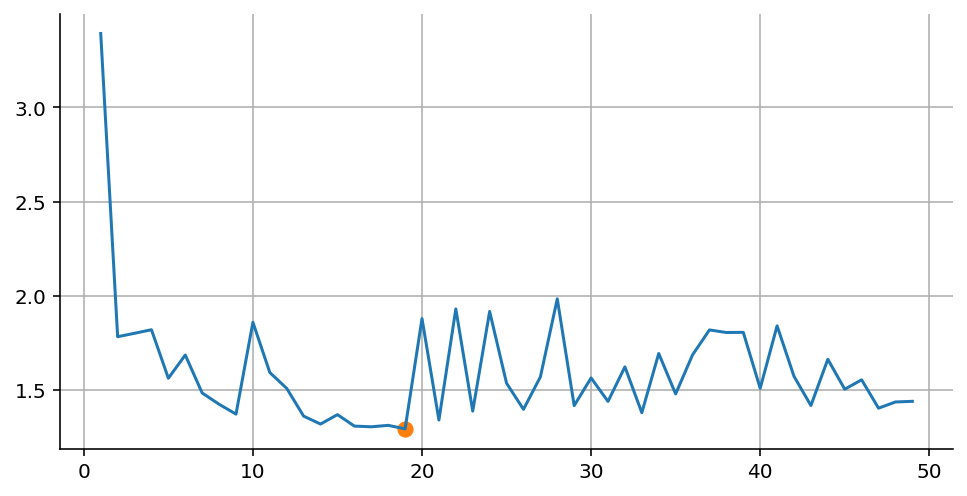

In [314]:
plt.plot(k_range, list_mae)
plt.scatter(best_k, best_mae, c="tab:orange", s=50)
plt.grid()

In [280]:
from statsmodels.tsa.arima_model import ARMA

In [281]:
arma = ARMA(temp_media_train.ffill(), (21, 0)).fit()

In [315]:
init_date = temp_media_test.index[0]
end_date = temp_media_test.index[-1]
yhat_arma = arma.predict(init_date, end_date)

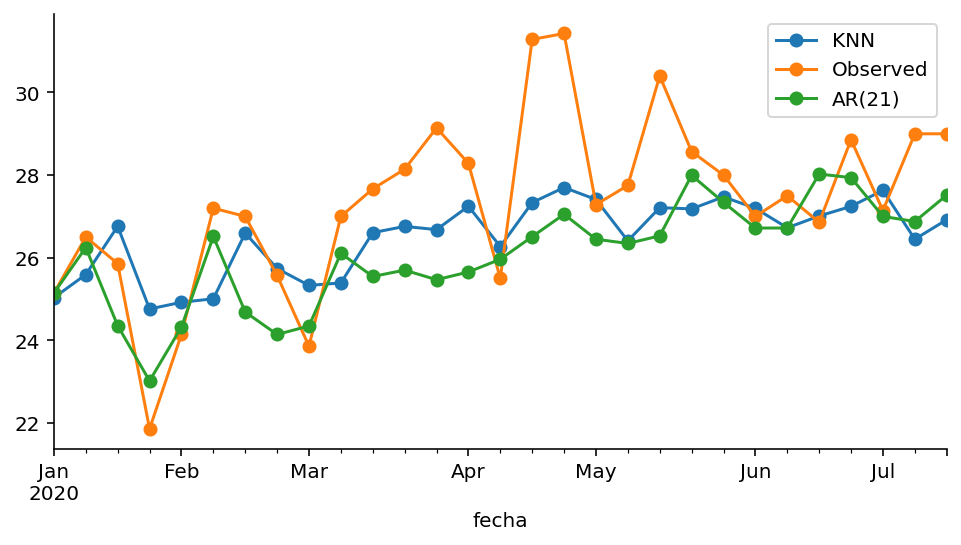

In [316]:
yhat_knn.plot(marker="o", label="KNN")
ytest.plot(marker="o", label="Observed")
yhat_arma.plot(marker="o", label="AR(21)")
plt.legend();

## Ensamble de modelos

In [317]:
yhat_ensamble = (yhat_arma + yhat_knn) / 2
mean_absolute_error(ytest, yhat_ensamble)

1.3939820912980994

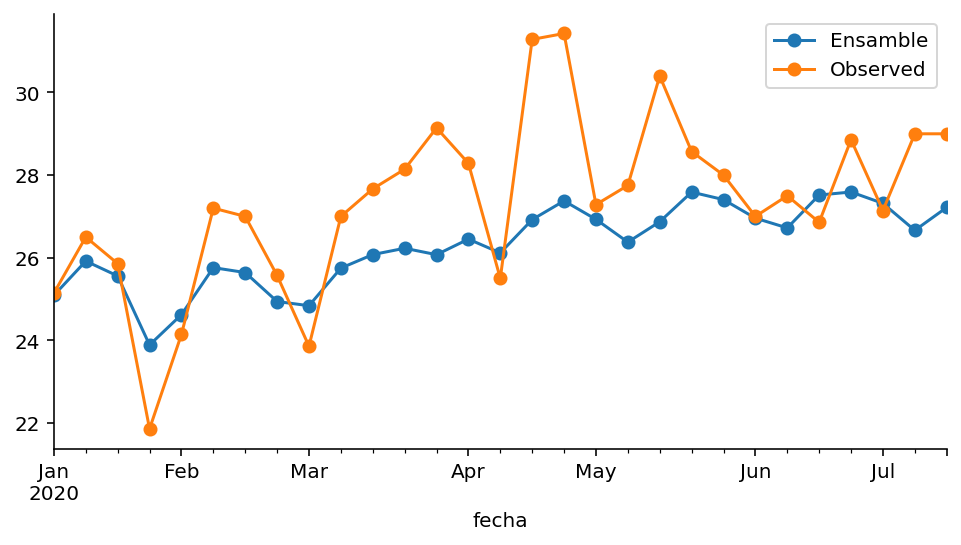

In [318]:
yhat_ensamble.plot(marker="o", label="Ensamble")
ytest.plot(marker="o", label="Observed")
plt.legend()

R^M -> R^K